# Practical Assignment 3

Authors: Abdullahi Ali, Pieter Wolfert

Recurrent neural networks can deal with sequential data (timeseries). In this assignment a recurrent neural network is implemented which learns to compute the sum of the previous and current input.

First we deal with the imports:

In [5]:
from __future__ import division

import numpy as np
import chainer
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.datasets import TupleDataset
import chainer.training as training
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from chainer import iterators
from chainer.cuda import to_cpu

### Implementation of RNN
To work with continous data instead of a classifier a regressor is build on top of the neural network chain. The RNN has one Long Short Term Memory layer and one fully connected layer. Before each forward pass we have to reset the state of the lstm layer. To achieve this, we have a reset_state method. Since we are dealing with a regression problem we use mean squared error as our loss function.

In [6]:
class RNN(Chain):
    """
    
    RNN implementation consisting of 1 lstm layer 
    and one fully connected layer
    
    """
    def __init__(self):
        super(RNN, self).__init__()
        with self.init_scope():
            self.lstm = L.LSTM(None,1) 
            self.linear = L.Linear(None,1)
                
    def reset_state(self):
        self.lstm.reset_state()

    def __call__(self, x):
        # Given the current input compute the sum
        h = self.lstm(x)
        y = self.linear(h)
        return y
                

class Regressor(Chain):
    """

    Regressor chain on top of Neural Network chain 
    for accuracy evaluation and prediction
 
    """
    def __init__(self, predictor):
        super(Regressor, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.mean_squared_error(y, t)
        return loss

### Backpropagation and model updating

The backprop through time updater (BPTT) is an extension of the chainer StandardUpdater which updates the network (and does a backpropagation) and evaluates with the test set. For each epoch we iterate over the entire training set (N = 3000) for each batch we compute the loss. Since its too costly to compute the loss for each timestep we use truncated backpropagation. We accumulate the loss for 30 timesteps and after 30 timesteps we backpropagate the accumulated loss and do a forward pass on the test data. We collect the training and test loss on the respective examples after each 30 timesteps and return these losses at the end of the loop. The code is adapted from the example RNN BPTT code from the chainer tutorials. 

In [32]:
class BPTTUpdater(chainer.training.StandardUpdater):
    """
    
    Class that implements backprogration through time (BPTT)
    
    """
    def __init__(self, train_iter,  optimizer, train_len, rnn):
        super(BPTTUpdater, self).__init__(train_iter, optimizer)
        self.train_len = train_len

    # The core part of the update routine
    def update_core(self):
        train_loss = []
        test_loss = []
        # When we pass one iterator and optimizer to StandardUpdater.__init__,
        # they are automatically named 'main'.
        train_iter = self.get_iterator('main')
        optimizer = self.get_optimizer('main')
        count = 0
        total_loss = 0
        # Progress the dataset iterator for train_len 
        for i in range(self.train_len):
            count += 1
            # Get the next batch 
            batch = train_iter.__next__()
            
            x, t = self.converter(batch)
            model.reset_state()
            # Compute the loss at this time step and accumulate it
            loss = optimizer.target(chainer.Variable(x), chainer.Variable(t))
            total_loss += loss
            if count % 30 == 0:
                optimizer.target.cleargrads()  # Clear the parameter gradients
                total_loss.backward()  # Backprop
                total_loss.unchain_backward()
                optimizer.update()  # Update the parameters
                train_loss.append(loss.data)
                #calculate test loss
                test_batch = test_iter.__next__()
                xtest, ttest = self.converter(test_batch)
                # Forward pass on the test data
                model.reset_state()
                loss_test = regressor(xtest, ttest)
                test_loss.append(loss_test.data)
        return train_loss, test_loss

#### Data creator method, as given in the course.

In [33]:
def create_data(n=3000):
    X = np.random.rand(n, 1).astype('float32')
    T = np.sum(np.hstack((X[0:-1], X[1:])), axis=1)
    T = np.hstack([0, T[0:]]).astype('float32')
    T = T.reshape([n, 1])

    return TupleDataset(X, T)

#### Visualisation function
A function to visualize training and test loss per epoch. 

In [34]:
def visualize_loss(train_loss, test_loss, nr_epochs=20):
    matplotlib.style.use('ggplot')
    figure = plt.figure(figsize=(10, 8))
    ax = figure.add_subplot(111)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    xticks = np.arange(1, nr_epochs+1, 1)
    ax.set_xticks(xticks)
    epochs = range(1, nr_epochs + 1)
    train, = plt.plot(epochs, train_loss, 'b', label='train loss')
    test, = plt.plot(epochs, test_loss, 'r', label='test loss')
    plt.legend([train, test], ['train loss', 'test loss'])
    plt.show()

#### The training loop 
The training loop at the bottom of the cell is at the core of training the RNN. First the data is loaded and iterators are instantiated. For this problem, it suffices to have batch sizes of 1. As a learning rate we choose 0.02, because this happenend to yield the best results. For this problem we experienced that the optimizer does not make a significant difference, so we use the standard SGD optimizer. 

In [35]:
#set the number of epochs
nr_epochs = 20
#retrieve the data
train_data = create_data()
test_data = create_data()
inputs, labels = np.array([tup[0] for tup in test_data]), np.array([tup[1] for tup in test_data])

#instantiating iterators
train_iter = iterators.SerialIterator(train_data, 1)
test_iter = iterators.SerialIterator(test_data, 1,repeat=False, shuffle=False)

#instantiating a model
model = RNN()
regressor = Regressor(model)

#choosing an optimizer
optimizer = chainer.optimizers.SGD(lr=0.02)
optimizer.setup(regressor)
updater = BPTTUpdater(train_iter, optimizer,3000, model)
train_loss, test_loss = [], []
#update network (evaluation is done within the loop)
for i in range(nr_epochs):
    loss_train, loss_test = updater.update_core()
    print('train loss: ' + str(np.mean(loss_train)),'test loss: ' + str(np.mean(loss_test)))
    train_loss.append(np.mean(loss_train))
    test_loss.append(np.mean(loss_test))
    model.reset_state()

('train loss: 0.134444', 'test loss: 0.110271')
('train loss: 0.104246', 'test loss: 0.0782963')
('train loss: 0.0996105', 'test loss: 0.0975632')
('train loss: 0.0993106', 'test loss: 0.0760751')
('train loss: 0.0770243', 'test loss: 0.0784752')
('train loss: 0.0953777', 'test loss: 0.0792092')
('train loss: 0.0931153', 'test loss: 0.0978135')
('train loss: 0.0985668', 'test loss: 0.0817924')
('train loss: 0.0827561', 'test loss: 0.101161')
('train loss: 0.0751401', 'test loss: 0.0749281')
('train loss: 0.08662', 'test loss: 0.0846843')
('train loss: 0.0920782', 'test loss: 0.0885505')
('train loss: 0.0850958', 'test loss: 0.0932831')
('train loss: 0.0774085', 'test loss: 0.0814735')
('train loss: 0.102293', 'test loss: 0.0914816')
('train loss: 0.0946211', 'test loss: 0.0986121')
('train loss: 0.100241', 'test loss: 0.100231')
('train loss: 0.0885968', 'test loss: 0.0857508')
('train loss: 0.0925603', 'test loss: 0.0996041')
('train loss: 0.0790285', 'test loss: 0.0872729')


### Part 1: Training and Test loss as a function of epoch number
In the figure the training/test loss is plotted against the epoch numbers. The training and test losses appear to fluctuate after the first epochs, but this is can be expected considering the small magnitudes of the losses.

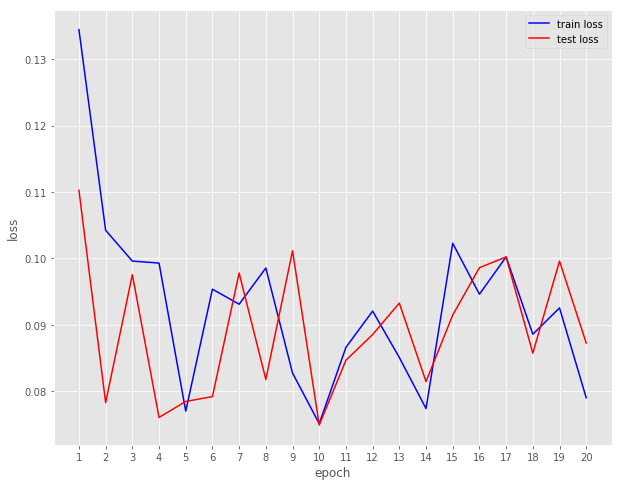

In [38]:
### visualise train and test loss for 20 epochs
visualize_loss(train_loss, test_loss, nr_epochs)

### Part 2: Actual vs. predicted output
In this part we visualise the first 100 timesteps of the RNN. We computed the predicted outputs and plotted these against the actual labels. The predictions do not perfectly fit with the actual output, but the shape of the curves are very similar

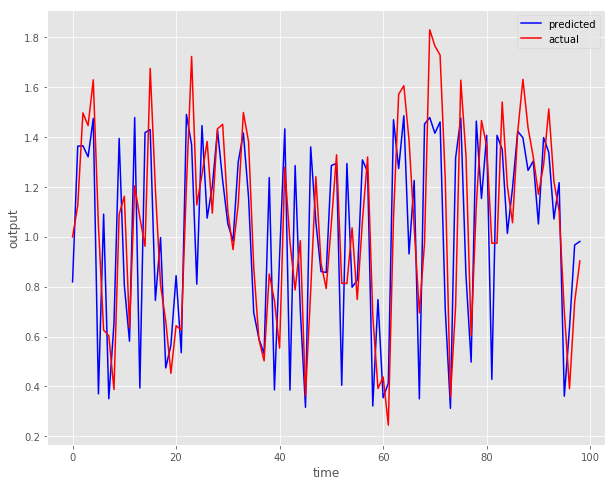

In [39]:
matplotlib.style.use('ggplot')
figure = plt.figure(figsize=(10, 8))
ax = figure.add_subplot(111)
ax.set_xlabel('time')
ax.set_ylabel('output')
new_inputs = inputs[1:100]
pred_inputs = model(new_inputs).data
actual_inputs = labels[1:100]
predicted, = plt.plot(pred_inputs, 'b', label='predicted')
actual, = plt.plot(actual_inputs, 'r',label='actual')
plt.legend([predicted, actual], ['predicted', 'actual'])
plt.show()
